# 佘山学堂
## DAS 数据读取和fk变换
作者:[Han Xiao](xiaohan@gfz-potsdam.de)

我首先介绍 HDF5 文件格式，并演示如何读取数据和访问元数据。 然后，我提供一些数据可视化和处理的基本示例。 
这些数据来自于PubDAS中西班牙Valencia的海底光纤DAS。

参考文献
Zack J. Spica, Jonathan Ajo‐Franklin, Gregory C. Beroza, Biondo Biondi, Feng Cheng, Beatriz Gaite, Bin Luo, Eileen Martin, Junzhu Shen, Clifford Thurber, Loïc Viens, Herbert Wang, Andreas Wuestefeld, Han Xiao, Tieyuan Zhu; PubDAS: A PUBlic Distributed Acoustic Sensing Datasets Repository for Geosciences. Seismological Research Letters 2023;; 94 (2A): 983–998. doi: https://doi.org/10.1785/0220220279

Xiao, H., Tanimoto, T., Spica, Z. J., Gaite, B., Ruiz‐Barajas, S., Pan, M., & Viens, L. (2022). Locating the precise sources of high‐frequency microseisms using distributed acoustic sensing. Geophysical Research Letters, 49(17), e2022GL099292.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py    
import numpy as np
import os, glob
from scipy import signal
from tqdm import tqdm
from scipy.signal import butter, lfilter, filtfilt

## 阅读 HDF5 文件并访问元数据
DAS 地震数据主要存储在 HDF5 中。HDF5 代表“分层数据格式，版本 5”。 HDF5 是传统地震数据格式的灵活替代方案，允许我们存储大量二进制数据以及适当的元数据。 HDF5 格式的一个主要优点是它允许高效切片——例如，您可以读取单个通道的数据，而无需将整个文件加载到内存中。 HDF5 的另一个优点是允许并发读/写操作，这对于并行计算应用来说很方便。

HDF5 文件包含两种类型的对象：组和数据集。 组将“层次结构”放入 HDF5 中，并且像文件夹一样，包含其他组或数据集。 数据集正如它们听起来的那样——实际的数据。 HDF5 文件中的所有对象都具有属性，即与该对象关联的元数据。 我们可以使用键访问对象或其属性，类似于 Python 字典的方式。

<img src='./DAS_Valencia2logos.jpg' alt='Logo' width=500 height=500>

下面我们来下载一段das数据，数据较大可能会有点慢

In [2]:
!wget 'https://zenodo.org/records/10143152/files/SR_Valencia_2020-09-02_21-32-00_UTC_10mins.h5'

--2023-11-16 15:47:59--  https://zenodo.org/records/10143152/files/SR_Valencia_2020-09-02_21-32-00_UTC_10mins.h5
Resolving zenodo.org (zenodo.org)... 188.184.103.159, 188.185.79.172, 188.184.98.238
Connecting to zenodo.org (zenodo.org)|188.184.103.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1789226584 (1.7G) [application/octet-stream]
Saving to: 'SR_Valencia_2020-09-02_21-32-00_UTC_10mins.h5.1'

SR_Valencia_2020-09 100%[===================>]   1.67G  7.28MB/s    in 4m 11s  

2023-11-16 15:52:11 (6.79 MB/s) - 'SR_Valencia_2020-09-02_21-32-00_UTC_10mins.h5.1' saved [1789226584/1789226584]



In [2]:
def display_hdf5_contents(file_path):
    with h5py.File(file_path, 'r') as file:
        def print_attrs(name, obj):
            print(name)
            for key, val in obj.attrs.items():
                print(f"  {key}: {val}")

        file.visititems(print_attrs)
file = './SR_Valencia_2020-09-02_21-32-00_UTC_10mins.h5'
display_hdf5_contents(file)

fa1-20050027
fa1-20050027/Source1
  AmpliPower: [27.]
  DataDomain: [4. 2.]
  FiberLength: [50000.]
  FreqRes: [250.]
  GaugeLength: [30.4]
  Hostname: b'fa1-20050027'
  Oversampling: [1.]
  PipelineTracker: b'Source'
  PulseRateFreq: [1000000.]
  SamplingRate: [250.]
  SamplingRes: [80.]
  WholeExtent: [    0. 62499.     0.  1999.     0.     0.]
fa1-20050027/Source1/Zone1
  AmpliPower: [27.]
  Components: [1.]
  DataDomain: [4. 2. 0.]
  Extent: [   0. 2976.    0.  999.    0.    0.]
  FiberLength: [5000.]
  FreqRes: b'250'
  GaugeLength: [30.4]
  Hostname: b'fa1-20050027'
  Origin: [0. 0. 0.]
  Oversampling: [1.]
  PipelineTracker: b'Source'
  PulseRateFreq: [1000000.]
  SamplingRate: [250.]
  SamplingRes: [80.]
  Spacing: [16.8  2.   1. ]
fa1-20050027/Source1/Zone1/SR_Valencia
fa1-20050027/Source1/time


这段代码定义了一个函数 display_hdf5_contents，该函数接受一个 HDF5 文件的路径作为参数，然后打开这个文件，遍历其中的内容并打印出来。类似于matlab中h5disp.
在这里我们可以获得一些有关采集的基本信息，包括标距、脉冲速率和空间采样间隔。

In [17]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# File Information
pathname = './'
filename = 'SR_Valencia_2020-09-02_21-32-00_UTC_10mins'
Zone_to_Plot = 1

# Time and Space Options
Section_time = 'yes'  # 'yes' to select a section of time
From_Time = 0  # seconds
To_Time = 300  # seconds

Section_space = 'yes'  # 'yes' to select a section of space
From_Position = 0.00  # Kilometers
To_Position = 50.0  # Kilometers

# Initialization
print(f"\n> Initialization\n{pathname}{filename}.h5")

with h5py.File(f"{pathname}{filename}.h5", "r") as file:
    das_name = list(file.keys())[0]  # Assuming the DAS unit is the first group
    source1 = file[das_name]['Source1']

    # Attributes
    frequency = source1.attrs['PulseRateFreq']
    freq_res = source1.attrs['FreqRes']/250
    acquisition_length = source1.attrs['FiberLength']
    SamplingRate = source1.attrs['SamplingRate']

    zone = source1[f'Zone{Zone_to_Plot}']
    origin = zone.attrs['Origin']
    spacing = zone.attrs['Spacing']
    extent = zone.attrs['Extent']

    zi_start = origin[0] + (extent[0]) * spacing[0]
    zi_end = origin[0] + (extent[1]) * spacing[0]
    distance_fiber = np.arange(zi_start, zi_end, spacing[0])

    # Dimensions
    strain_rate_dataset = zone['SR_Valencia']
    nb_block, block_time_size, block_space_size = strain_rate_dataset.shape
    time_0 = source1['time'][()]

# Processing Time and Space Sections
if Section_time == 'no':
    first_block = 0
    last_block = nb_block - 1
else:
    first_block = int(From_Time * freq_res)
    last_block = int(To_Time * freq_res)

if Section_space == 'no':
    first_point = 0
    last_point = block_space_size
else:
    first_point = np.abs(distance_fiber - From_Position * 1000).argmin()
    last_point = np.abs(distance_fiber - To_Position * 1000).argmin()

# Data Extraction
print("\n> Data extraction")
strain_rate = np.array([])
with h5py.File(f"{pathname}{filename}.h5", "r") as file:
    for tt in range(first_block, last_block):
        data = file[f"{das_name}/Source1/Zone1/SR_Valencia"][tt,:,first_point:last_point]
        strain_rate = np.hstack([strain_rate, data.T]) if strain_rate.size else data.T


> Initialization
./SR_Valencia_2020-09-02_21-32-00_UTC_10mins.h5

> Data extraction


这里的采样率为 250 Hz，2976个channel，10分钟的数据我们可以看到，正如预期的那样，十分钟有 600 x 250 x 2976 = 446400000 个样本。
现在我们了解了 HDF5 中的组、数据集和属性如何工作，让我们看一下实际的 DAS 数据。 它存储在`file["fa1-20050027/Source1/Zone1/SR_Valencia"]`的数据集对象中。 这是一个 3D 数据集（时间-采样率-通道/距离）。 该顺序由记录软件用户开关确定，允许以跟踪顺序或通道顺序存储数据。 通常，第一轴是时间，第二轴是采样率，第三轴是通道数，用于快速时域处理，并且在整个记录过程中通常是恒定的。 读取文件时最好检查该属性值。

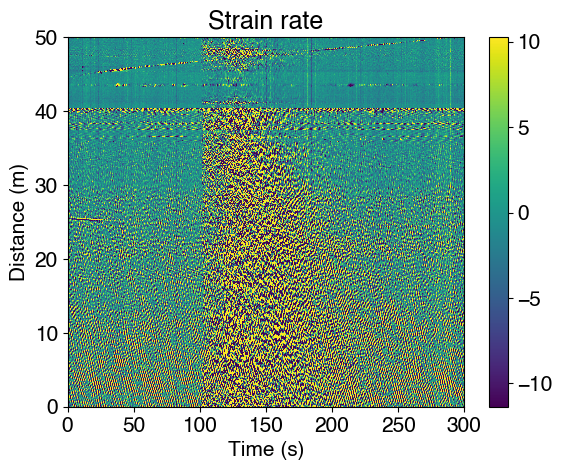

In [18]:
# Plotting
plt.figure()
vmin=-(np.max(strain_rate)-np.min(strain_rate))*0.001+np.mean(strain_rate)
vmax=(np.max(strain_rate)-np.min(strain_rate))*0.001+np.mean(strain_rate)
plt.imshow(strain_rate,extent=[From_Time, To_Time, From_Position, To_Position],vmin=vmin, vmax=vmax,aspect='auto')

plt.colorbar()
plt.xlabel('Time (s)')
plt.ylabel('Distance (m)')
plt.title('Strain rate')
plt.show()

这里我们展示了一个地震事件，接下来我们要使用fk变换来计算海洋波浪的速度

In [19]:
def spectral_normalization(data):
    """Compute simple Whitening of a trace.
    :type data: numpy.array
    :param data: the data
    :return: specrtral normalized data
    """
    spec = np.fft.rfft(data)
    spec /= np.abs(spec)+1
    data = np.fft.irfft(spec)
    del spec
    return data
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

这里我们定义了一些预处理的函数，包括频谱白化，滤波等

In [20]:
nx = strain_rate.shape[0] # number of channels 
ns = strain_rate.shape[1] # number of samples
fs = SamplingRate[0]   # sampling rate (Hz)
dx = spacing[0]           # channel spacing (m)
for j in range(0, strain_rate.shape[1]):
   strain_rate[:,j] = strain_rate[:,j]-np.mean(strain_rate[:,j],axis=0)# 减去仪器common mode 噪音
for j in range(0, nx):
   strain_rate[j,:] = spectral_normalization(strain_rate[j,:]) # 谱白化

x = np.arange(nx) * dx # 距离 单位为米
t = np.arange(ns) / fs # 时间 单位为秒

xmin = 0
xmax = nx*dx
idx = np.logical_and(x>=xmin,x<=xmax)

tmin = 0
tmax = ns/fs
idt = np.logical_and(t>=tmin,t<=tmax)

data_slice = strain_rate[np.ix_(idx,idt)]
xx = x[idx]
tt = t[idt]
# Apply two FFTs to get the FK spectrum
fk = np.fft.fft2(data_slice)
fk = np.fft.fftshift(fk)
fk = 20*np.log10(abs(fk))

# Get FK axes
f = np.fft.fftshift(np.fft.fftfreq(len(tt),d=1./fs))
k = np.fft.fftshift(np.fft.fftfreq(len(xx),d=dx))     

这里我们进行简单的一维fk变换

Text(0, 0.5, 'Wavenumber (1/m)')

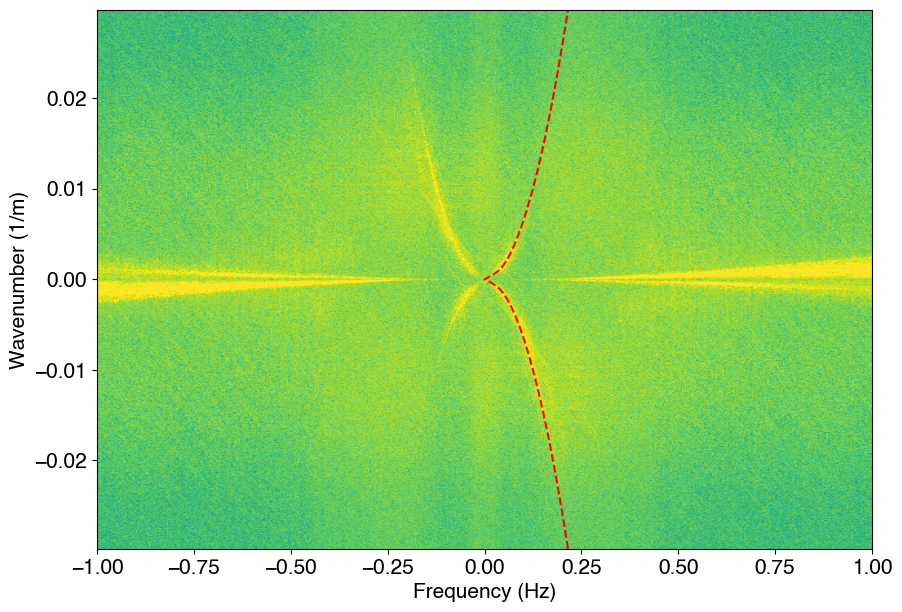

In [21]:
import matplotlib
font = {'family' : 'Helvetica',
        'weight' : 'normal',
        'size'   : 15}
matplotlib.rc('font', **font)

plt.figure(figsize=(10, 7))
vmin=(np.max(fk)-np.min(fk))*0.2+np.min(fk)
vmax=np.max(fk)-(np.max(fk)-np.min(fk))*0.2
plt.imshow(fk[:,int(ns/2-300):int(ns/2+300)],extent=[f[int(ns/2-300)], f[int(ns/2+300)],k[0], k[-1]],cmap='viridis',vmin=vmin,vmax=vmax,aspect='auto')

h=220#根据这个水深来计算理论频散曲线
f_OSGW = np.sqrt(9.8*2*np.pi*k * np.tanh(2*np.pi*k*h)) * (0.5/np.pi)
plt.plot(f_OSGW,k,'r--')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Wavenumber (1/m)')

这里我们画出了这段时间fk变换后的，频率波数域的图，其中x轴是频率，y轴是波数。红色的虚线代表了计算的海洋波浪的在水深为220米（光纤的平均水深）时候的频散曲线。请注意这只是一个一维数据的直接变换，所以我们只能得到两个传播方向，分辨是海向的和陆向的。
从图中可以看出我们可以很好的与我们的观测结果相吻合。另外在海洋波浪的右侧，我们可以看到很多的地震噪音，或者叫microseisms。关于这方面的研究还请参考我们都放在最前面的文献。